In [6]:
# imports
!pip install "cloudpathlib[azure]" loguru tqdm typer rasterio pandas_path xarray-spatial
!pip install imagecorruptions
!pip install --upgrade git+https://github.com/aleju/imgaug.git

import pandas as pd
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
import xarray
import xrspatial.multispectral as ms
import PIL
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [ ]:
RAW_DATA_PATH='../data/raw/'
INTERIM_DATA_PATH='../data/raw/'
PROCESSED_DATA_PATH='../data/raw/'
FUNTIONS_PATH='../functions/'

In [159]:
train_metadata=pd.read_csv(RAW_DATA_PATH+'train_metadata.csv')
!python FUNTIONS_PATH+'download_data.py' --cloud-directory "az://./train_labels" --sas-url RAW_DATA_PATH+'sas_centralus.txt' --local-directory RAW_DATA_PATH
!python FUNTIONS_PATH+'download_data.py' --cloud-directory "az://./train_features" --sas-url RAW_DATA_PATH+'sas_centralus.txt' --local-directory RAW_DATA_PATH

Text(0.5, 1.0, 'True color image for chip id utyb')

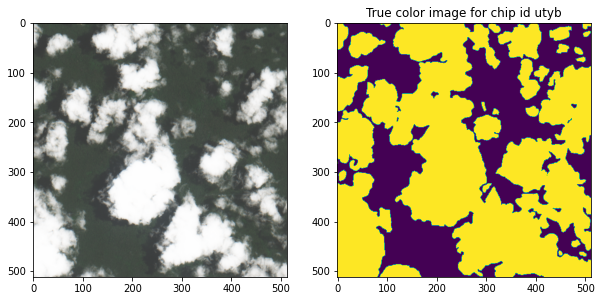

In [160]:
SEED=42

def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(PIL.Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir=RAW_DATA_PATH+'train_features/'):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = data_dir+chip_id
    red = get_xarray(chip_dir+"/B04.tif")
    green = get_xarray(chip_dir+ "/B03.tif")
    blue = get_xarray(chip_dir+ "/B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

random_image_index=np.random.randint(train_metadata.shape[0])
random_image_chip_id=train_metadata.chip_id[random_image_index]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10))
im = true_color_img(random_image_chip_id)
ax1.imshow(im)
plt.title(f"True color image for chip id {random_image_chip_id}")
im = get_xarray(RAW_DATA_PATH+'train_labels/train_labels/'+random_image_chip_id+'.tif')
ax2.imshow(im.data)
plt.title(f"True color image for chip id {random_image_chip_id}")



Lets check out if there are images that are labelled uncorrectly.

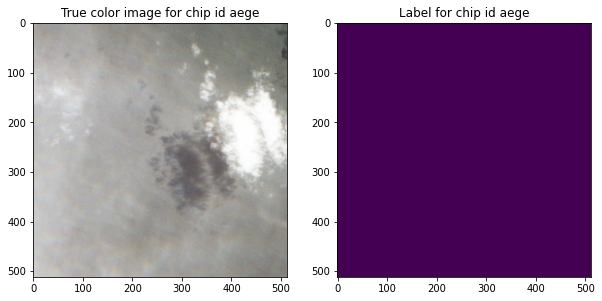

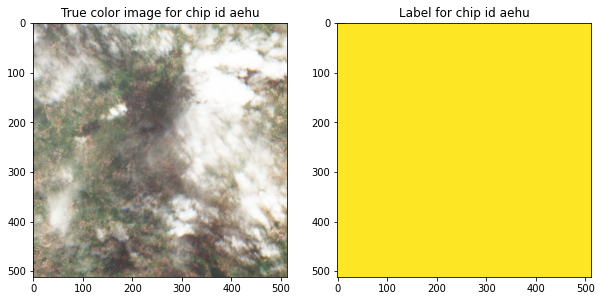

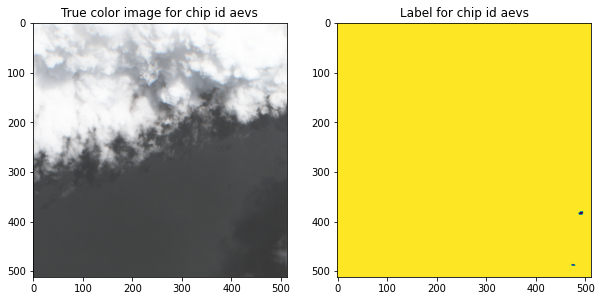

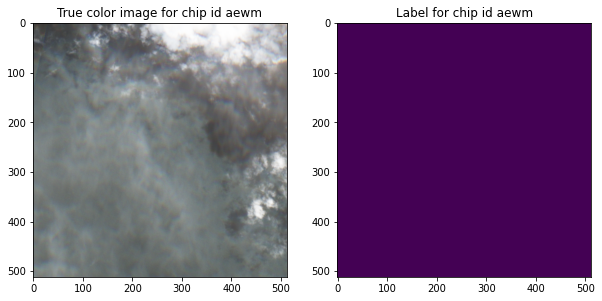

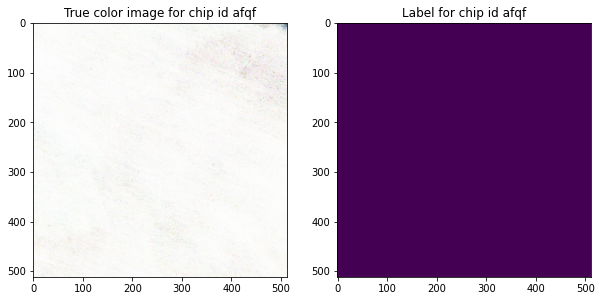

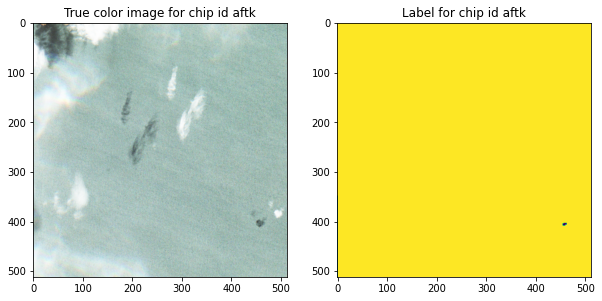

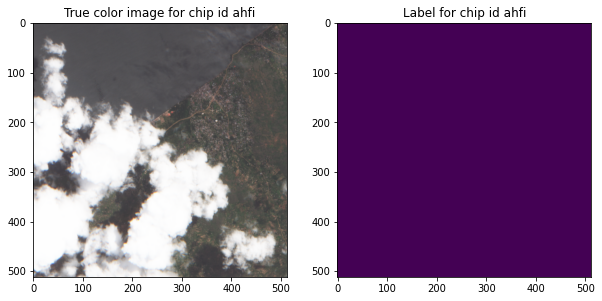

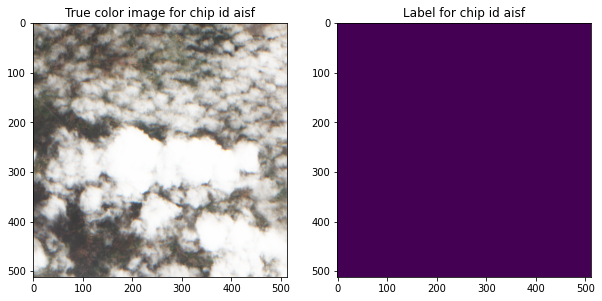

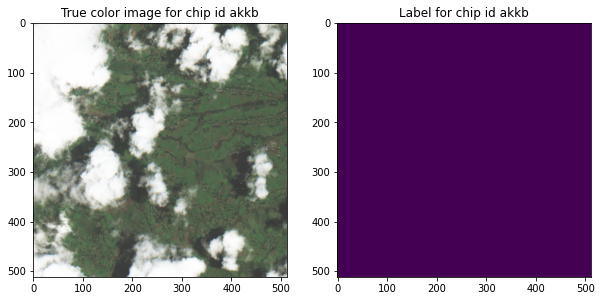

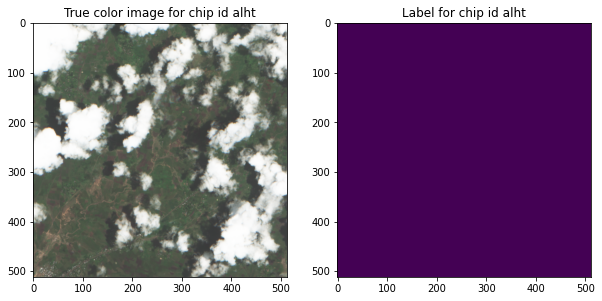

In [182]:

def plot_pair(image,label,chip):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10))
    ax2.imshow(label)
    ax2.set_title(f"Label for chip id {chip}")
    ax1.imshow(image)
    ax1.set_title(f"True color image for chip id {chip}")
    plt.show()
    
all_0_image_count=0
all_1_image_count=0
faulty_images_count=0
faulty_chips=[]
max_images=5
for chip in train_metadata.chip_id:
    label = get_xarray(RAW_DATA_PATH+'train_labels/train_labels/'+chip+'.tif').data
    if label.sum()>=(512*512)*0.999:
        im=true_color_img(chip).data
        if (im>200).sum()/512/512/3<.75:
            faulty_chips.append(chip)
            faulty_images_count+=1
            if all_1_image_count<max_images:
                plot_pair(im,label,chip)
                all_1_image_count+=1
    elif label.sum()==0 :
        im=true_color_img(chip).data
        if (im<130).sum()/512/512/3<.75:
            faulty_chips.append(chip)
            faulty_images_count+=1
            if all_0_image_count< max_images:
                plot_pair(im,label,chip)
                all_0_image_count+=1
### Note 'afqf' is an example where it is fully cloudy yet the segmentation map is all 0 

In [183]:
print('Total number of Faulty images detected: ',faulty_images_count)

Total number of Faulty images detected:  1254


In [184]:
train_metadata=train_metadata[~train_metadata['chip_id'].isin(faulty_chips)]

image pair before augmentation


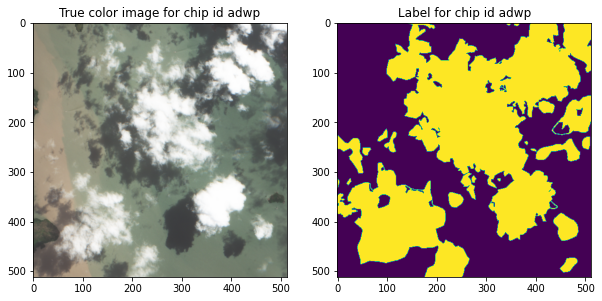

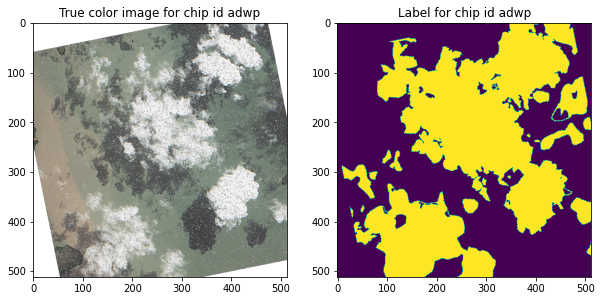

image pair before augmentation


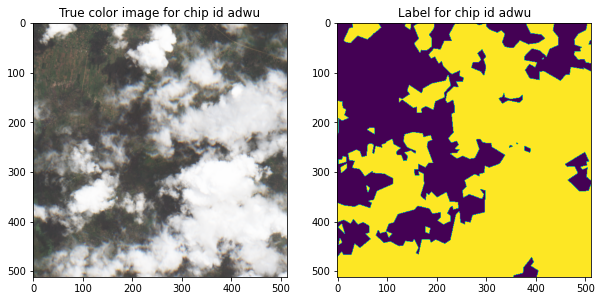

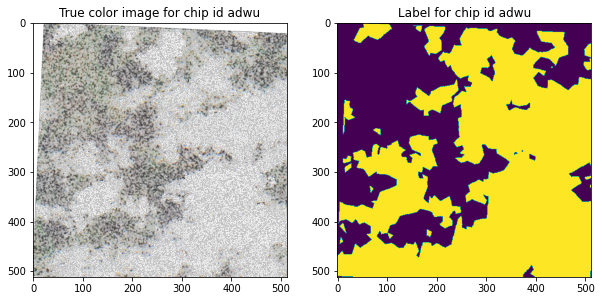

image pair before augmentation


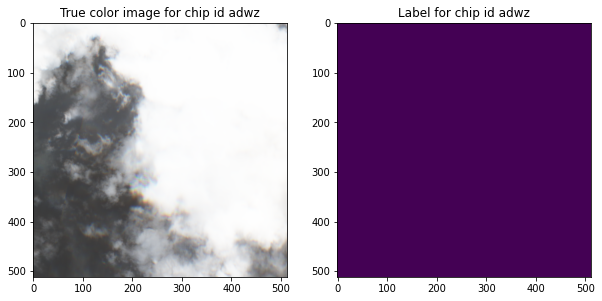

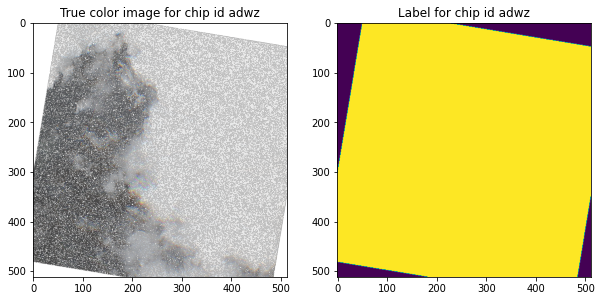

image pair before augmentation


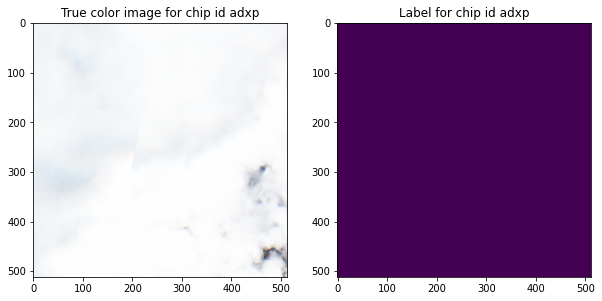

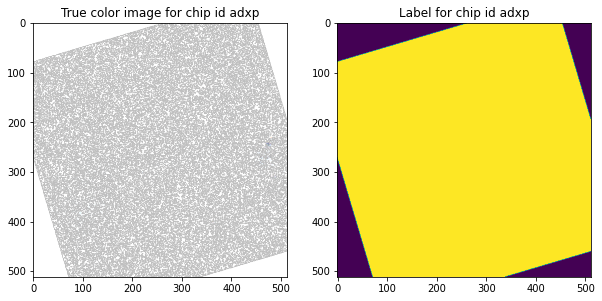

image pair before augmentation


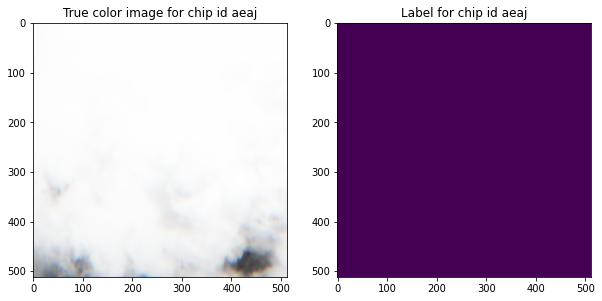

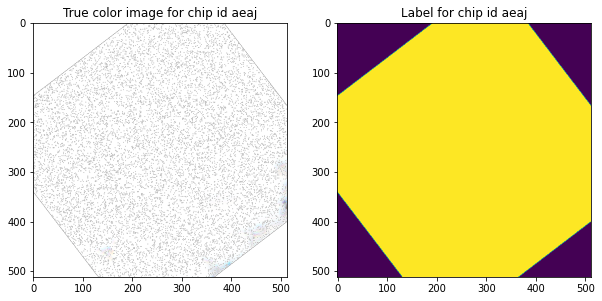

image pair before augmentation


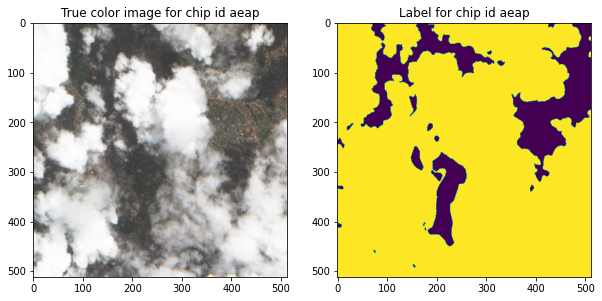

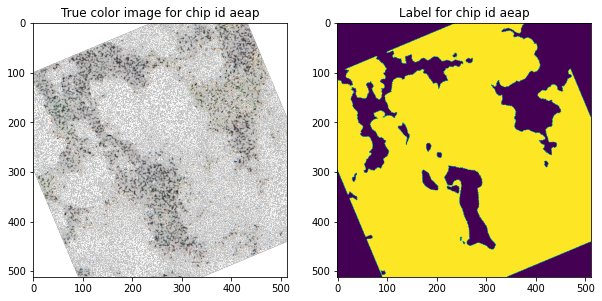

image pair before augmentation


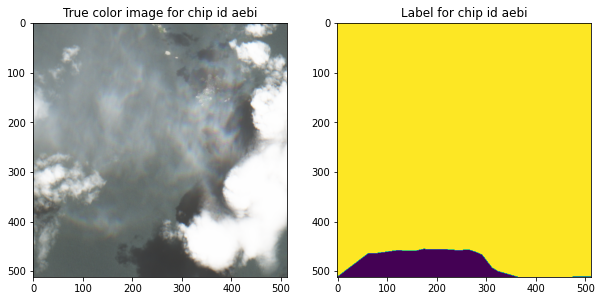

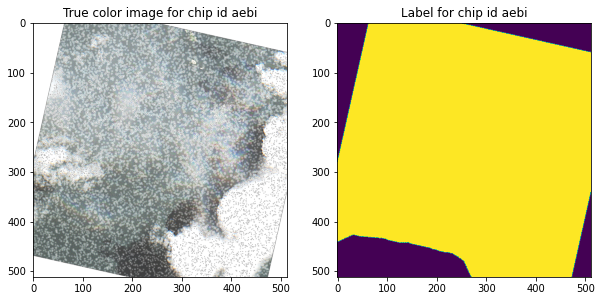

image pair before augmentation


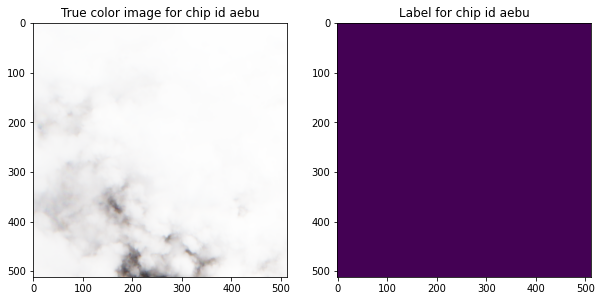

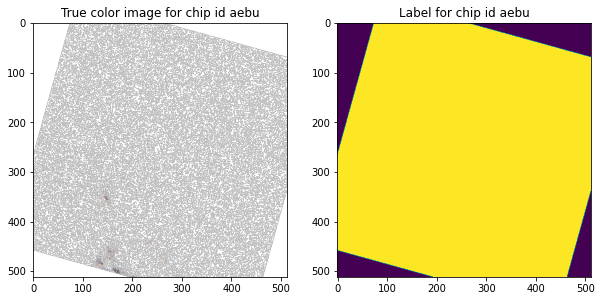

image pair before augmentation


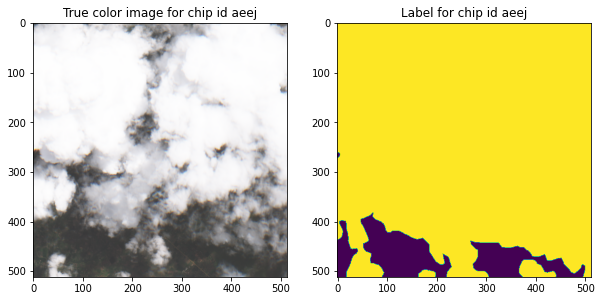

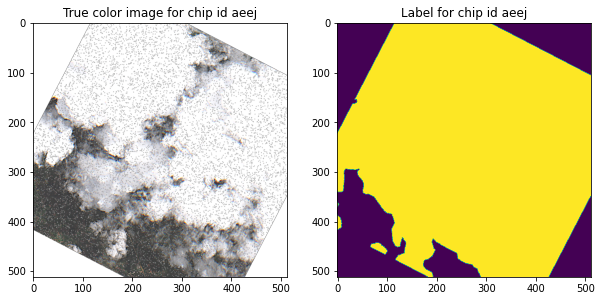

image pair before augmentation


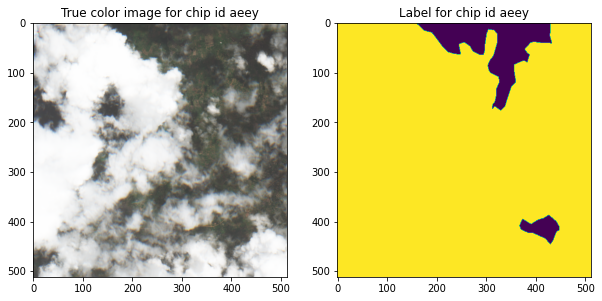

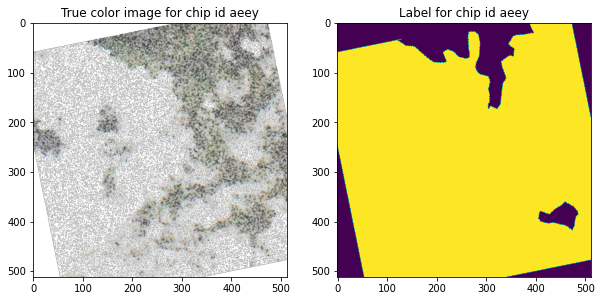

In [185]:
# lets apply rand augmentation to some images and see how they look
###############################################################################
# PLEASE NOTE THAT Augmentation here augments the segmented labels too.
# Hence this is experimental and at this point I cannot be sure if this 
# would improve the performance (we will compare both with and without augmentation)
###############################################################################

for chip in train_metadata.chip_id[:10]:
    image = true_color_img(chip).data
    segmap = get_xarray(RAW_DATA_PATH+'train_labels/train_labels/'+chip+'.tif').data
    print('image pair before augmentation')
    plot_pair(image,segmap,chip)
    segmap = SegmentationMapsOnImage(segmap, shape=image.shape)
    seq = iaa.Sequential([
    iaa.Dropout([0.05, 0.2]),      # drop 5% or 20% of all pixels
    iaa.Sharpen((0.0, 1.0)),       # sharpen the image
    iaa.geometric.Affine(rotate=(-45, 45),mode='constant',cval=0,translate_px=10)  # rotate by -45 to 45 degrees (affects segmaps)
    # iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects segmaps)
    ], random_order=True)
    images_aug_i, segmaps_aug_i = seq(image=image, segmentation_maps=segmap)
    plot_pair(images_aug_i,segmaps_aug_i.arr.reshape(512,512),chip)

#### Also note the edges of the true color images are set to black (val=0) 
#### eventhough the seem to be white due the ploting by pyplot

In [177]:
image = true_color_img('afqf').data

In [178]:
(image>200).sum()/512/512/3<.75

False

In [180]:
label=get_xarray(RAW_DATA_PATH+'train_labels/train_labels/'+'afqf'+'.tif').data

In [181]:
label.sum()

0